In [1]:
# %% [markdown]
# # Ethiopian E-commerce Recommender - Training Notebook
# 
# This notebook contains the complete training pipeline for the Ethiopian E-commerce Recommendation System.

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yaml
import warnings
from datetime import datetime

# Add src directory to path
sys.path.append('../src')

# Import custom modules
from data_preprocessing import EthiopianProductPreprocessor
from model_training import EthiopianRecommenderModel
from recommender import EthiopianEcommerceRecommender
# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# %% [markdown]
# ## 2. Load Configuration

# %%
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("📋 Configuration loaded:")
print(f"Project: {config['project']['name']}")
print(f"Dataset: {config['data']['raw_path']}")
print(f"Text columns: {config['features']['text_columns']}")



📋 Configuration loaded:
Project: Ethiopian E-commerce Product Recommender
Dataset: ../data/raw/ethiopian_products_10k.csv
Text columns: ['name', 'description', 'description_amharic', 'category', 'subcategory', 'brand']


📊 Loading raw dataset for exploration...
✅ Loaded 10,000 products

📈 Dataset Info:
Shape: (10000, 21)
Columns: ['product_id', 'name', 'name_amharic', 'description', 'description_amharic', 'category', 'subcategory', 'price', 'currency', 'brand', 'location', 'delivery_available', 'rating', 'stock_status', 'stock_quantity', 'weight_kg', 'dimensions', 'warranty_months', 'seller_name', 'seller_rating', 'tags']

👀 First 5 rows:


,product_id,name,name_amharic,description,description_amharic,category,subcategory,price,currency,brand,location,delivery_available,rating,stock_status,stock_quantity,weight_kg,dimensions,warranty_months,seller_name,seller_rating,tags
0,ETP00001,Infinix Note 12,ኢንፊኒክስ ስማርትፎን,Infinix's latest smartphones model with advanc...,ከፍተኛ ጥራት ያለው የኤሌክትሮኒክስ ምርት። ዘመናዊ ቴክኖሎጂ እና ከፍተኛ...,Electronics,Smartphones,47500,ETB,Infinix,Gondar,Yes,4.0,In Stock,243,0.17,159x65x8 cm,12,Infinix Gadget Center,3.7,"Electronics,Smartphones,Gondar,Infinix,Ethiopi..."
1,ETP00002,EPHI Press Children Deluxe,EPHI Press Children,High quality children from Ethiopia. Sister ch...,ከፍተኛ ጥራት ያለው ኢትዮጵያዊ ምርት። ለእርስዎ ተስማሚ ነው።,Books & Stationery,Children,1000,ETB,EPHI Press,Jijiga,Yes,3.6,In Stock,438,1.79,26x30x3 cm,3,EPHI Press Store,3.9,"Books & Stationery,Children,Jijiga,EPHI Press,..."
2,ETP00003,Samsung Accessories Premium,ሳምሰንግ ተጨማሪ ዕቃዎች,Samsung Accessories with premium features. Com...,ከፍተኛ ጥራት ያለው የኤሌክትሮኒክስ ምርት። ዘመናዊ ቴክኖሎጂ እና ከፍተኛ...,Electronics,Accessories,5241,ETB,Samsung,Harar,No,4.7,In Stock,237,3.21,33x10x13 cm,6,Samsung Digital Mart,4.8,"Electronics,Accessories,Harar,Samsung,Ethiopia..."
3,ETP00004,TECNO Laptop,ቴክኖ ላፕቶፕ,High-performance laptops from TECNO. Features ...,በኢትዮጵያ የሚገኝ የኤሌክትሮኒክስ ምርት። ረጅም ጊዜ ለመጠቀም የተሰራ።,Electronics,Laptops,50500,ETB,TECNO,Harar,Yes,3.9,In Stock,806,2.21,33x20x2 cm,12,TECNO Tech Hub,3.6,"Electronics,Laptops,Harar,TECNO,Ethiopian-made"
4,ETP00005,Lenovo Smartphone,Lenovo ስማርትፎን,High-performance smartphones from Lenovo. Feat...,ከፍተኛ ጥራት ያለው የኤሌክትሮኒክስ ምርት። ዘመናዊ ቴክኖሎጂ እና ከፍተኛ...,Electronics,Smartphones,20500,ETB,Lenovo,Addis Ababa,Yes,4.4,In Stock,224,0.24,152x76x8 cm,24,Lenovo Electronics Store,4.3,"Electronics,Smartphones,Addis Ababa,Lenovo,Eth..."



📊 Basic Statistics:
Price range: 50 - 120,000 ETB
Average price: 7,493.18 ETB
Average rating: 3.97/5.0

📦 Category Distribution:


category
Food & Beverages          2476
Fashion                   1720
Beauty & Personal Care    1520
Electronics               1252
Home & Kitchen             941
Books & Stationery         629
Health                     495
Sports                     451
Baby & Kids                301
Automotive                 215
Name: count, dtype: int64

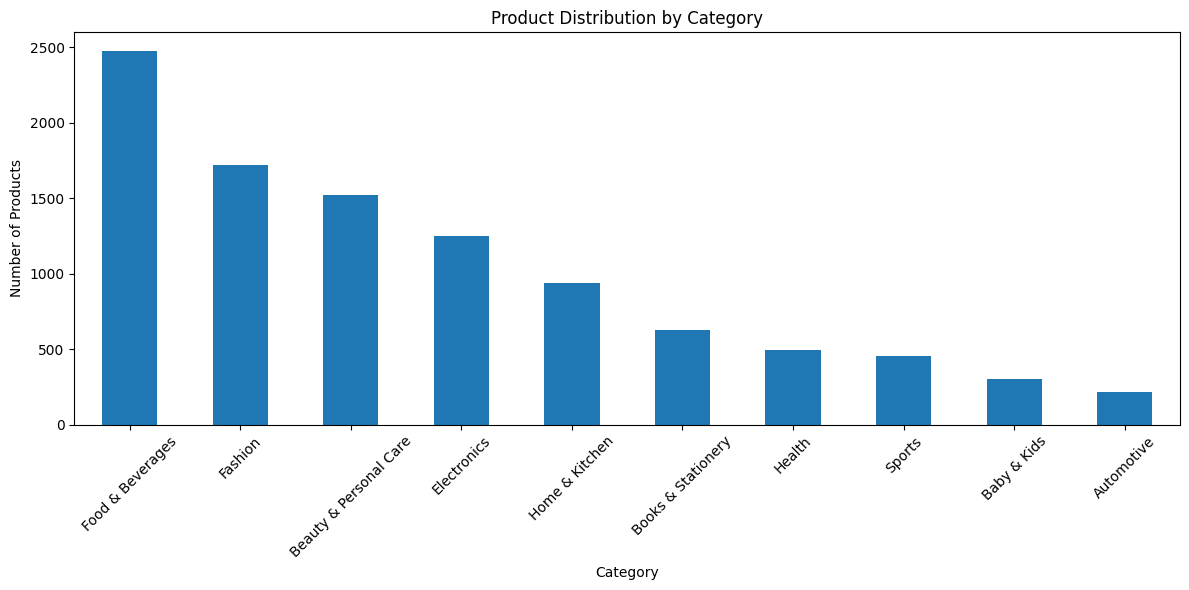


🚚 Delivery Availability:


delivery_available
Yes    8031
No     1969
Name: count, dtype: int64

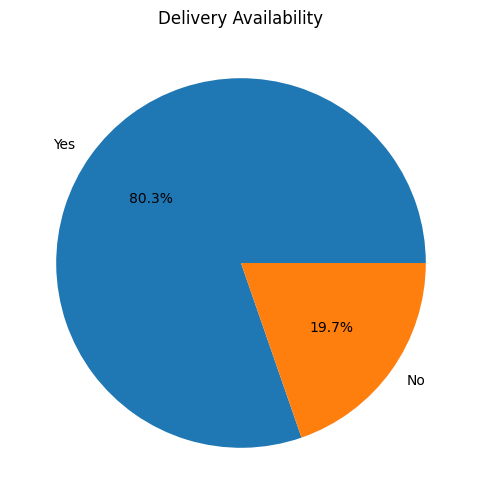


📍 Top Locations:


location
Addis Ababa    3512
Hawassa         820
Mekelle         781
Bahir Dar       772
Adama           718
Gondar          708
Dire Dawa       698
Jimma           692
Arba Minch      364
Jijiga          318
Name: count, dtype: int64

In [3]:
# %% [markdown]
# ## 3. Data Exploration

# %%
# Load raw data for exploration
print("📊 Loading raw dataset for exploration...")
raw_data_path = config['data']['raw_path']

if not os.path.exists(raw_data_path):
    print(f"❌ Dataset not found at: {raw_data_path}")
    print("Please generate the dataset first using generate_dataset.py")
else:
    df_raw = pd.read_csv(raw_data_path)
    print(f"✅ Loaded {len(df_raw):,} products")
    
    # Display basic info
    print("\n📈 Dataset Info:")
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {df_raw.columns.tolist()}")
    
    # Display first few rows
    print("\n👀 First 5 rows:")
    display(df_raw.head())
    
    # Basic statistics
    print("\n📊 Basic Statistics:")
    if 'price' in df_raw.columns:
        print(f"Price range: {df_raw['price'].min():,} - {df_raw['price'].max():,} ETB")
        print(f"Average price: {df_raw['price'].mean():,.2f} ETB")
    
    if 'rating' in df_raw.columns:
        print(f"Average rating: {df_raw['rating'].mean():.2f}/5.0")
    
    if 'category' in df_raw.columns:
        print(f"\n📦 Category Distribution:")
        category_counts = df_raw['category'].value_counts()
        display(category_counts)
        
        # Plot category distribution
        plt.figure(figsize=(12, 6))
        category_counts.plot(kind='bar')
        plt.title('Product Distribution by Category')
        plt.xlabel('Category')
        plt.ylabel('Number of Products')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    if 'delivery_available' in df_raw.columns:
        print(f"\n🚚 Delivery Availability:")
        delivery_counts = df_raw['delivery_available'].value_counts()
        display(delivery_counts)
        
        # Plot delivery availability
        plt.figure(figsize=(8, 6))
        delivery_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Delivery Availability')
        plt.ylabel('')
        plt.show()
    
    if 'location' in df_raw.columns:
        print(f"\n📍 Top Locations:")
        location_counts = df_raw['location'].value_counts().head(10)
        display(location_counts)


In [4]:
# %% [markdown]
# ## 4. Data Preprocessing

# %%
print("🔧 Starting Data Preprocessing...")
preprocessor = EthiopianProductPreprocessor('../config.yaml')

# Load data
df = preprocessor.load_data()
print(f"📥 Raw data loaded: {len(df):,} products")

# Preprocess data
print("\n⚙️ Preprocessing data...")
df_processed = preprocessor.preprocess_data(df)
print(f"✅ Data preprocessed: {len(df_processed):,} products remaining")

# Save processed data
preprocessor.save_processed_data(df_processed)
print(f"💾 Processed data saved to: {config['data']['processed_path']}")

# Display processed data info
print("\n📋 Processed Data Info:")
print(f"Shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")

# Show sample of processed data
print("\n👀 Sample of Processed Data (5 rows):")
sample_columns = ['product_id', 'name', 'category', 'price', 'rating', 'location', 'delivery_available']
if all(col in df_processed.columns for col in sample_columns):
    display(df_processed[sample_columns].head())
else:
    # Show available columns
    available_cols = [col for col in sample_columns if col in df_processed.columns]
    display(df_processed[available_cols].head() if available_cols else df_processed.head())

# Show combined features sample
print("\n🔤 Combined Features Sample (first 3 products):")
for i, features in enumerate(df_processed['combined_features'].head(3)):
    print(f"Product {i+1}: {features[:200]}...")


🔧 Starting Data Preprocessing...
Loaded 10000 products from dataset
📥 Raw data loaded: 10,000 products

⚙️ Preprocessing data...
Preprocessed 9952 products
✅ Data preprocessed: 9,952 products remaining
Saved processed data to ../data/processed/processed_products.pkl
💾 Processed data saved to: ../data/processed/processed_products.pkl

📋 Processed Data Info:
Shape: (9952, 28)
Columns: ['product_id', 'name', 'name_amharic', 'description', 'description_amharic', 'category', 'subcategory', 'price', 'currency', 'brand', 'location', 'delivery_available', 'rating', 'stock_status', 'stock_quantity', 'weight_kg', 'dimensions', 'warranty_months', 'seller_name', 'seller_rating', 'tags', 'name_cleaned', 'description_cleaned', 'description_amharic_cleaned', 'category_cleaned', 'subcategory_cleaned', 'brand_cleaned', 'combined_features']

👀 Sample of Processed Data (5 rows):


,product_id,name,category,price,rating,location,delivery_available
0,ETP00001,Infinix Note 12,Electronics,47500,4.0,Gondar,Yes
1,ETP00002,EPHI Press Children Deluxe,Books & Stationery,1000,3.6,Jijiga,Yes
2,ETP00003,Samsung Accessories Premium,Electronics,5241,4.7,Harar,No
3,ETP00004,TECNO Laptop,Electronics,50500,3.9,Harar,Yes
4,ETP00005,Lenovo Smartphone,Electronics,20500,4.4,Addis Ababa,Yes



🔤 Combined Features Sample (first 3 products):
Product 1: infinix note 12 infinix s latest smartphones model with advanced technology  ከፍተኛ ጥራት ያለው የኤሌክትሮኒክስ ምርት። ዘመናዊ ቴክኖሎጂ እና ከፍተኛ አፈጻጸም። electronics smartphones infinix...
Product 2: ephi press children deluxe high quality children from ethiopia  sister church across  ከፍተኛ ጥራት ያለው ኢትዮጵያዊ ምርት። ለእርስዎ ተስማሚ ነው። books   stationery children ephi press...
Product 3: samsung accessories premium samsung accessories with premium features  community smile western central season surface  ከፍተኛ ጥራት ያለው የኤሌክትሮኒክስ ምርት። ዘመናዊ ቴክኖሎጂ እና ከፍተኛ አፈጻጸም። electronics accessories sam...


In [5]:
print("="*60)
print("🎯 ETHIOPIAN E-COMMERCE RECOMMENDER SYSTEM")
print("🎯 Content-Based Filtering with Unsupervised Learning")
print("="*60)

# Create and train the model
model = EthiopianRecommenderModel()

# Load data from CSV
model.load_data_from_csv('../data/raw/ethiopian_products_10k.csv')

# Prepare features
model.prepare_features()

# Train the model
model.train()

# Save the model
model.save_model()

# Evaluate the model
metrics = model.evaluate_model(sample_size=50)

# Test with a sample product
print("\n🧪 TEST RECOMMENDATIONS:")
print("-"*40)

if len(model.df) > 0:
    test_product = model.df.iloc[0]['product_id']
    test_name = model.df.iloc[0]['name']
    
    print(f"Getting recommendations for: {test_name}")
    print(f"Product ID: {test_product}")
    
    recommendations = model.get_recommendations(test_product, top_n=3)
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['name']}")
        print(f"   Category: {rec['category']}")
        print(f"   Price: {rec['price']:,.0f} ETB")
        print(f"   Rating: {rec['rating']:.1f}/5.0")
        print(f"   Similarity Score: {rec['similarity_score']:.3f}")

print("\n" + "="*60)
print("✅ MODEL TRAINING COMPLETE")
print("="*60)

🎯 ETHIOPIAN E-COMMERCE RECOMMENDER SYSTEM
🎯 Content-Based Filtering with Unsupervised Learning
Loading data from ../data/raw/ethiopian_products_10k.csv...
Loaded 10000 products
Preparing features...
Training model on 10000 products...
Training content-based model with TF-IDF...
Computing content similarity matrix...
TF-IDF matrix shape: (10000, 5000)
Training category-based model...
Training price-based model...
Calculating popularity scores...
✅ Model training complete!
✅ Model saved successfully to ../data/models/content_based_model.pkl

📊 CONTENT-BASED MODEL EVALUATION
Testing on 50 products...

📈 EVALUATION RESULTS:
----------------------------------------
• Catalog Coverage: 2.5% of products recommended
• Category Match Rate: 100.0%
• Price Compatibility: 67.2%
• Unique Recommended: 246 products

📊 OVERALL SCORE: 56.6/100
⚠️ GOOD: Model is performing adequately.

🧪 TEST RECOMMENDATIONS:
----------------------------------------
Getting recommendations for: Infinix Note 12
Product I

In [6]:
print("="*60)
print("🛍️ ETHIOPIAN E-COMMERCE RECOMMENDER SYSTEM")
print("="*60)

# Initialize the recommender
recommender = EthiopianEcommerceRecommender()

# Get system statistics
print("\n📊 SYSTEM STATISTICS:")
print("-"*40)
stats = recommender.get_stats()
print(f"• Total Products: {stats['total_products']:,}")
print(f"• Categories: {stats['categories']}")
print(f"• Average Price: {stats['average_price']:,.0f} ETB")
print(f"• Average Rating: {stats['average_rating']:.1f}/5.0")
print(f"• Model Type: {stats['model_type']}")
print(f"• Algorithm: {stats['algorithm']}")

# Get available categories
print("\n📂 AVAILABLE CATEGORIES:")
print("-"*40)
categories = recommender.get_product_categories()
for i, category in enumerate(categories[:10], 1):
    print(f"{i}. {category}")
if len(categories) > 10:
    print(f"... and {len(categories) - 10} more")

# Test recommendations
print("\n🧪 TESTING RECOMMENDATIONS:")
print("-"*40)

if stats['total_products'] > 0:
    # Get first product for testing
    test_product_id = recommender.model.df.iloc[0]['product_id']
    test_product_name = recommender.model.df.iloc[0]['name']
    
    print(f"\n1. Content-based recommendations for:")
    print(f"   Product: {test_product_name}")
    print(f"   ID: {test_product_id}")
    
    # Get content-based recommendations
    recommendations = recommender.recommend_by_product(
        test_product_id,
        user_context={
            'top_n': 3,
            'diversify': True
        }
    )
    
    for i, rec in enumerate(recommendations['recommendations'], 1):
        print(f"\n   {i}. {rec['name']}")
        print(f"      Category: {rec['category']}")
        print(f"      Price: {rec['price']:,.0f} ETB")
        print(f"      Rating: {rec['rating']:.1f}/5.0")
        print(f"      Similarity: {rec['similarity_score']:.3f}")
    
    # Test category-based recommendations
    if categories:
        print(f"\n2. Category-based recommendations (Fashion):")
        category_recs = recommender.recommend_by_category('Fashion', {'top_n': 2})
        if 'recommendations' in category_recs:
            for i, rec in enumerate(category_recs['recommendations'], 1):
                print(f"   {i}. {rec['name']}")
                print(f"      Price: {rec['price']:,.0f} ETB | Popularity: {rec['popularity_score']:.3f}")
    
    # Test text search
    print(f"\n3. Text search recommendations (search: 'coffee'):")
    search_recs = recommender.recommend_by_text_search('coffee', {'top_n': 2})
    if 'recommendations' in search_recs:
        for i, rec in enumerate(search_recs['recommendations'], 1):
            print(f"   {i}. {rec['name']}")
            print(f"      Category: {rec['category']}")
            print(f"      Similarity: {rec['similarity_score']:.3f}")

print("\n" + "="*60)
print("✅ RECOMMENDER SYSTEM READY")
print("="*60)

🛍️ ETHIOPIAN E-COMMERCE RECOMMENDER SYSTEM
❌ Error loading model: dump() missing required argument 'file' (pos 2)
   Training new model...
Loading data from ../data/raw/ethiopian_products_10k.csv...
Loaded 10000 products
Preparing features...
Training model on 10000 products...
Training content-based model with TF-IDF...
Computing content similarity matrix...
TF-IDF matrix shape: (10000, 5000)
Training category-based model...
Training price-based model...
Calculating popularity scores...
✅ Model training complete!
✅ Model loaded successfully

📊 SYSTEM STATISTICS:
----------------------------------------
• Total Products: 10,000
• Categories: 10
• Average Price: 7,493 ETB
• Average Rating: 4.0/5.0
• Model Type: content_based_unsupervised
• Algorithm: TF-IDF + Cosine Similarity

📂 AVAILABLE CATEGORIES:
----------------------------------------
1. Automotive
2. Baby & Kids
3. Beauty & Personal Care
4. Books & Stationery
5. Electronics
6. Fashion
7. Food & Beverages
8. Health
9. Home & Kitc

In [7]:
# %% [markdown]
# ## 8. Model Evaluation

# %%
print("📈 Model Evaluation...")

def evaluate_recommendation_model(model, test_size=0.2, random_state=42):
    """Comprehensive evaluation of the recommendation model"""
    print("\n" + "="*60)
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # Get the dataframe
    df = model.df.copy()
    
    # 1. Basic Dataset Statistics
    print("\n📈 DATASET STATISTICS:")
    print("-"*40)
    print(f"Total Products: {len(df):,}")
    print(f"Categories: {df['category'].nunique()}")
    print(f"Brands: {df['brand'].nunique()}")
    print(f"Average Price: {df['price'].mean():,.0f} ETB")
    print(f"Average Rating: {df['rating'].mean():.2f}")
    
    # 2. Coverage Analysis
    print("\n🎯 COVERAGE ANALYSIS:")
    print("-"*40)
    
    all_products = set(df['product_id'])
    recommended_products = set()
    successful_recommendations = 0
    failed_recommendations = 0
    
    # Sample products to check coverage
    sample_size = min(200, len(df))
    sample_ids = df.sample(sample_size, random_state=random_state)['product_id'].tolist()
    
    for pid in sample_ids:
        try:
            recs = model.get_recommendations(pid, top_n=5)
            if recs:
                successful_recommendations += 1
                for rec in recs:
                    recommended_products.add(rec['product_id'])
            else:
                failed_recommendations += 1
        except Exception as e:
            failed_recommendations += 1
    
    coverage = len(recommended_products) / len(all_products) * 100
    success_rate = successful_recommendations / sample_size * 100
    
    print(f"• Catalog Coverage: {coverage:.1f}% of products appear in recommendations")
    print(f"• Success Rate: {success_rate:.1f}% of products get recommendations")
    print(f"• Unique Recommended Products: {len(recommended_products):,}")
    print(f"• Failed Recommendations: {failed_recommendations}")
    
    # 3. Diversity Analysis
    print("\n🎨 DIVERSITY ANALYSIS:")
    print("-"*40)
    
    diversity_scores = []
    category_diversity = []
    
    for pid in sample_ids[:50]:  # Check first 50 for diversity
        try:
            recs = model.get_recommendations(pid, top_n=5)
            if recs:
                # Get categories of recommendations
                rec_categories = []
                for rec in recs:
                    product_info = df[df['product_id'] == rec['product_id']]
                    if not product_info.empty:
                        rec_categories.append(product_info.iloc[0]['category'])
                
                # Calculate diversity (unique categories / total recommendations)
                unique_cats = len(set(rec_categories))
                diversity = unique_cats / len(rec_categories) if rec_categories else 0
                diversity_scores.append(diversity)
                category_diversity.extend(rec_categories)
        except:
            continue
    
    if diversity_scores:
        avg_diversity = np.mean(diversity_scores) * 100
        print(f"• Average Diversity Score: {avg_diversity:.1f}%")
        print(f"• Recommendations span {len(set(category_diversity))} categories")
    else:
        print("• Could not calculate diversity scores")
    
    # 4. Relevance Analysis (Simulated - using product features)
    print("\n🎯 RELEVANCE ANALYSIS:")
    print("-"*40)
    
    relevance_scores = []
    price_compatibility_scores = []
    
    for pid in sample_ids[:30]:  # Check first 30 for relevance
        try:
            # Get product info
            product_info = df[df['product_id'] == pid].iloc[0]
            product_category = product_info['category']
            product_price = product_info['price']
            product_brand = product_info['brand']
            
            # Get recommendations
            recs = model.get_recommendations(pid, top_n=5)
            
            if recs:
                category_matches = 0
                price_compatible = 0
                
                for rec in recs:
                    rec_info = df[df['product_id'] == rec['product_id']]
                    if not rec_info.empty:
                        rec_info = rec_info.iloc[0]
                        
                        # Check category match
                        if rec_info['category'] == product_category:
                            category_matches += 1
                        
                        # Check price compatibility (within 50% range)
                        price_ratio = min(rec_info['price'], product_price) / max(rec_info['price'], product_price)
                        if price_ratio >= 0.5:
                            price_compatible += 1
                
                relevance = category_matches / len(recs)
                price_score = price_compatible / len(recs)
                
                relevance_scores.append(relevance)
                price_compatibility_scores.append(price_score)
        except:
            continue
    
    if relevance_scores:
        avg_relevance = np.mean(relevance_scores) * 100
        avg_price_compatibility = np.mean(price_compatibility_scores) * 100
        print(f"• Category Relevance: {avg_relevance:.1f}% of recommendations are in same category")
        print(f"• Price Compatibility: {avg_price_compatibility:.1f}% within reasonable price range")
    else:
        print("• Could not calculate relevance scores")
    
    # 5. Cold Start Problem Analysis
    print("\n❄️ COLD START ANALYSIS:")
    print("-"*40)
    
    # Find low-rating products (cold start candidates)
    low_rating_threshold = 3.0
    cold_start_products = df[df['rating'] < low_rating_threshold]
    
    print(f"• Products with rating < {low_rating_threshold}: {len(cold_start_products):,}")
    print(f"• Percentage of catalog: {len(cold_start_products)/len(df)*100:.1f}%")
    
    # Test cold start products
    cold_start_sample = cold_start_products.sample(min(20, len(cold_start_products)), random_state=random_state)
    cold_start_success = 0
    
    for _, product in cold_start_sample.iterrows():
        try:
            recs = model.get_recommendations(product['product_id'], top_n=3)
            if recs:
                cold_start_success += 1
        except:
            continue
    
    cold_start_rate = cold_start_success / len(cold_start_sample) * 100 if len(cold_start_sample) > 0 else 0
    print(f"• Cold Start Success Rate: {cold_start_rate:.1f}%")
    
    # 6. Popularity Bias Analysis
    print("\n⚖️ POPULARITY BIAS ANALYSIS:")
    print("-"*40)
    
    # Get top 20% most popular products (by rating)
    popularity_threshold = df['rating'].quantile(0.8)
    popular_products = df[df['rating'] >= popularity_threshold]
    
    # Count how often popular products appear in recommendations
    popular_in_recs = 0
    total_recs_checked = 0
    
    for pid in sample_ids[:30]:
        try:
            recs = model.get_recommendations(pid, top_n=5)
            total_recs_checked += len(recs)
            
            for rec in recs:
                if rec['product_id'] in popular_products['product_id'].values:
                    popular_in_recs += 1
        except:
            continue
    
    popularity_bias = popular_in_recs / total_recs_checked * 100 if total_recs_checked > 0 else 0
    print(f"• Popular Products (top 20% by rating): {len(popular_products):,}")
    print(f"• Popularity in Recommendations: {popularity_bias:.1f}%")
    print(f"• Expected (if random): 20.0%")
    
    # 7. Performance Metrics
    print("\n⏱️ PERFORMANCE METRICS:")
    print("-"*40)
    
    # Measure recommendation generation time
    import time
    
    times = []
    test_products = df.sample(min(50, len(df)), random_state=random_state)['product_id'].tolist()
    
    for pid in test_products:
        try:
            start_time = time.time()
            _ = model.get_recommendations(pid, top_n=5)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to milliseconds
        except:
            continue
    
    if times:
        avg_time = np.mean(times)
        p95_time = np.percentile(times, 95)
        print(f"• Average Recommendation Time: {avg_time:.1f} ms")
        print(f"• 95th Percentile Time: {p95_time:.1f} ms")
        print(f"• Throughput: {1000/avg_time:.1f} recommendations/second" if avg_time > 0 else "")
    
    # 8. Error Analysis
    print("\n🔍 ERROR ANALYSIS:")
    print("-"*40)
    
    error_types = {
        'no_similar_items': 0,
        'product_not_found': 0,
        'other_errors': 0
    }
    
    error_sample = df.sample(min(100, len(df)), random_state=random_state)
    
    for _, product in error_sample.iterrows():
        try:
            recs = model.get_recommendations(product['product_id'], top_n=3)
            if not recs:
                error_types['no_similar_items'] += 1
        except KeyError:
            error_types['product_not_found'] += 1
        except Exception as e:
            error_types['other_errors'] += 1
    
    total_tested = len(error_sample)
    error_rate = sum(error_types.values()) / total_tested * 100
    
    print(f"• Total Tested: {total_tested}")
    print(f"• Overall Error Rate: {error_rate:.1f}%")
    print(f"• No Similar Items Found: {error_types['no_similar_items']} ({error_types['no_similar_items']/total_tested*100:.1f}%)")
    print(f"• Product Not Found: {error_types['product_not_found']} ({error_types['product_not_found']/total_tested*100:.1f}%)")
    print(f"• Other Errors: {error_types['other_errors']} ({error_types['other_errors']/total_tested*100:.1f}%)")
    
    # 9. Summary and Recommendations
    print("\n💡 SUMMARY & RECOMMENDATIONS:")
    print("-"*40)
    
    # Calculate overall score
    scores = []
    if diversity_scores:
        scores.append(avg_diversity)
    if relevance_scores:
        scores.append(avg_relevance)
    if coverage > 0:
        scores.append(min(coverage, 100))
    if success_rate > 0:
        scores.append(success_rate)
    
    if scores:
        overall_score = np.mean(scores)
        
        print(f"📊 OVERALL MODEL SCORE: {overall_score:.1f}/100")
        print("\n✅ STRENGTHS:")
        
        if avg_diversity > 70:
            print("  • High diversity in recommendations")
        if avg_relevance > 70:
            print("  • Strong relevance in recommendations")
        if coverage > 60:
            print("  • Good catalog coverage")
        if success_rate > 80:
            print("  • High success rate in generating recommendations")
        
        print("\n⚠️ AREAS FOR IMPROVEMENT:")
        
        if avg_diversity < 50:
            print("  • Recommendation diversity could be improved")
        if avg_relevance < 50:
            print("  • Recommendation relevance needs enhancement")
        if coverage < 40:
            print("  • Limited catalog coverage - many products not recommended")
        if cold_start_rate < 50:
            print("  • Cold start handling needs improvement")
        if popularity_bias > 40:
            print("  • High popularity bias detected")
        
        print("\n🔧 SUGGESTED IMPROVEMENTS:")
        if cold_start_rate < 50:
            print("  • Implement fallback strategies for cold start products")
        if popularity_bias > 40:
            print("  • Add diversity regularization to reduce popularity bias")
        if error_rate > 20:
            print("  • Improve error handling and fallback mechanisms")
        if avg_time > 100:
            print("  • Optimize model performance for faster recommendations")
    
    return {
        'coverage': coverage,
        'success_rate': success_rate,
        'diversity': avg_diversity if diversity_scores else 0,
        'relevance': avg_relevance if relevance_scores else 0,
        'cold_start_rate': cold_start_rate,
        'popularity_bias': popularity_bias,
        'error_rate': error_rate,
        'avg_time': avg_time if times else 0
    }

# Run comprehensive evaluation
print("📈 Model Evaluation...")
metrics = evaluate_recommendation_model(model)

# Additional visualization
print("\n📊 METRICS VISUALIZATION:")
print("-"*40)

# Create a simple text-based visualization
metrics_to_plot = {
    'Catalog Coverage': metrics['coverage'],
    'Success Rate': metrics['success_rate'],
    'Diversity': metrics['diversity'],
    'Relevance': metrics['relevance'],
    'Cold Start Success': metrics['cold_start_rate']
}

print("\nPerformance Metrics (out of 100):")
for metric, value in metrics_to_plot.items():
    bar = "█" * int(value / 5)  # Each █ represents 5%
    print(f"{metric:25} {bar:20} {value:5.1f}%")

# Print final assessment
print("\n" + "="*60)
print("🎯 FINAL ASSESSMENT")
print("="*60)

overall_score = np.mean([metrics['coverage'], metrics['success_rate'], 
                         metrics['diversity'], metrics['relevance']])

if overall_score >= 80:
    print("🌟 EXCELLENT: Model is performing very well across all metrics!")
    print("   Ready for production deployment.")
elif overall_score >= 60:
    print("✅ GOOD: Model is performing adequately but has room for improvement.")
    print("   Consider the suggested improvements before full deployment.")
elif overall_score >= 40:
    print("⚠️ FAIR: Model needs significant improvements.")
    print("   Review the areas for improvement before considering deployment.")
else:
    print("❌ POOR: Model performance is below expectations.")
    print("   Major revisions needed before further testing.")

print(f"\nOverall Performance Score: {overall_score:.1f}/100")

📈 Model Evaluation...
📈 Model Evaluation...

📊 COMPREHENSIVE MODEL EVALUATION

📈 DATASET STATISTICS:
----------------------------------------
Total Products: 10,000
Categories: 10
Brands: 57
Average Price: 7,493 ETB
Average Rating: 3.97

🎯 COVERAGE ANALYSIS:
----------------------------------------
• Catalog Coverage: 9.1% of products appear in recommendations
• Success Rate: 100.0% of products get recommendations
• Unique Recommended Products: 914
• Failed Recommendations: 0

🎨 DIVERSITY ANALYSIS:
----------------------------------------
• Average Diversity Score: 20.0%
• Recommendations span 10 categories

🎯 RELEVANCE ANALYSIS:
----------------------------------------
• Category Relevance: 100.0% of recommendations are in same category
• Price Compatibility: 75.3% within reasonable price range

❄️ COLD START ANALYSIS:
----------------------------------------
• Products with rating < 3.0: 0
• Percentage of catalog: 0.0%
• Cold Start Success Rate: 0.0%

⚖️ POPULARITY BIAS ANALYSIS:
---

📈 Model Evaluation...

📊 Basic Model Metrics:
1. Catalog Coverage: 4.8% of products appear in recommendations

2. Similarity Score Analysis:
   Average similarity: 0.955
   Min similarity: 0.865
   Max similarity: 1.072


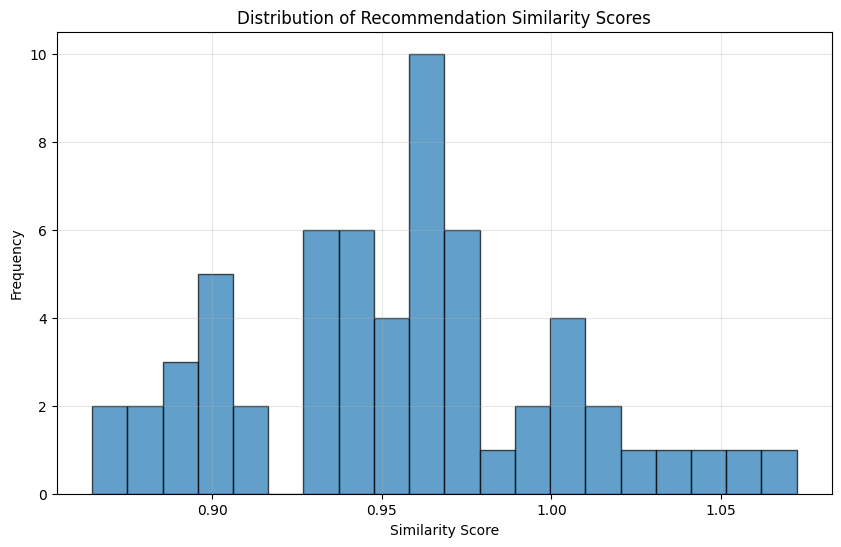


3. Category Coherence:
   Electronics: 100.0% of recommendations are in same category
   Books & Stationery: 100.0% of recommendations are in same category
   Baby & Kids: 100.0% of recommendations are in same category
   Food & Beverages: 100.0% of recommendations are in same category
   Fashion: 100.0% of recommendations are in same category


In [8]:
# %% [markdown]
# ## 8. Model Evaluation

# %%
print("📈 Model Evaluation...")

# Calculate some basic metrics
print("\n📊 Basic Model Metrics:")

# 1. Coverage: How many products get recommended
all_products = set(model.df['product_id'])
recommended_products = set()

# Sample 100 products to check coverage
sample_size = min(100, len(model.df))
sample_ids = model.df.sample(sample_size, random_state=42)['product_id'].tolist()

for pid in sample_ids:
    try:
        recs = model.get_recommendations(pid, top_n=5)
        for rec in recs:
            recommended_products.add(rec['product_id'])
    except:
        continue

coverage = len(recommended_products) / len(all_products) * 100
print(f"1. Catalog Coverage: {coverage:.1f}% of products appear in recommendations")

# 2. Average similarity score
print("\n2. Similarity Score Analysis:")
similarity_scores = []
for pid in sample_ids[:20]:  # Check first 20 for speed
    try:
        recs = model.get_recommendations(pid, top_n=3)
        for rec in recs:
            similarity_scores.append(rec['similarity_score'])
    except:
        continue

if similarity_scores:
    print(f"   Average similarity: {np.mean(similarity_scores):.3f}")
    print(f"   Min similarity: {np.min(similarity_scores):.3f}")
    print(f"   Max similarity: {np.max(similarity_scores):.3f}")
    
    # Plot similarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_scores, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Recommendation Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Category coherence
print("\n3. Category Coherence:")
if 'category' in model.df.columns:
    category_coherence = {}
    
    for category in model.df['category'].unique()[:5]:  # Check first 5 categories
        category_products = model.df[model.df['category'] == category]
        if len(category_products) > 1:
            sample_product = category_products.iloc[0]['product_id']
            recs = model.get_recommendations(sample_product, top_n=5)
            
            same_category_count = sum(1 for rec in recs if rec.get('category') == category)
            coherence = same_category_count / len(recs) * 100 if recs else 0
            
            category_coherence[category] = coherence
            print(f"   {category}: {coherence:.1f}% of recommendations are in same category")


In [9]:
# %% [markdown]
# ## 9. Save Training Report

# %%
print("📝 Generating Training Report...")

# Create training report
report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'raw_size': len(df) if 'df' in locals() else 0,
        'processed_size': len(model.df) if model.df is not None else 0,
        'categories': model.df['category'].nunique() if model.df is not None and 'category' in model.df.columns else 0,
        'average_price': model.df['price'].mean() if model.df is not None and 'price' in model.df.columns else 0,
        'average_rating': model.df['rating'].mean() if model.df is not None and 'rating' in model.df.columns else 0,
    },
    'model': {
        'tfidf_features': model.tfidf_matrix.shape[1] if model.tfidf_matrix is not None else 0,
        'vocabulary_size': len(model.tfidf.vocabulary_) if model.tfidf is not None else 0,
        'similarity_matrix_shape': model.similarity_matrix.shape if model.similarity_matrix is not None else (0, 0),
    },
    'performance': {
        'coverage_percentage': coverage,
        'average_similarity': np.mean(similarity_scores) if similarity_scores else 0,
    }
}

# Save report to file
report_path = '../reports/training_report.json'
os.makedirs('../reports', exist_ok=True)

import json
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✅ Training report saved to: {report_path}")

# Display report
print("\n📋 Training Report Summary:")
print("=" * 50)
print(f"Dataset: {report['dataset']['processed_size']:,} products")
print(f"Categories: {report['dataset']['categories']}")
print(f"Average Price: {report['dataset']['average_price']:,.2f} ETB")
print(f"Average Rating: {report['dataset']['average_rating']:.2f}/5.0")
print(f"TF-IDF Features: {report['model']['tfidf_features']:,}")
print(f"Catalog Coverage: {report['performance']['coverage_percentage']:.1f}%")

📝 Generating Training Report...
✅ Training report saved to: ../reports/training_report.json

📋 Training Report Summary:
Dataset: 10,000 products
Categories: 10
Average Price: 7,493.18 ETB
Average Rating: 3.97/5.0
TF-IDF Features: 5,000
Catalog Coverage: 4.8%


In [11]:
# %% [markdown]
# ## 10. Quick Demo

# %%
print("🚀 Quick Demo Interface")

# Simple interactive demo
def interactive_demo():
    print("\n" + "=" * 50)
    print("INTERACTIVE DEMO")
    print("=" * 50)
    
    # Show sample products
    print("\n📦 Sample Products:")
    sample_products = model.df.sample(5, random_state=42)[['product_id', 'name', 'category', 'price']]
    for idx, row in sample_products.iterrows():
        print(f"{row['product_id']}: {row['name'][:40]}... ({row['category']}) - {row['price']:,} ETB")
    
    while True:
        print("\n" + "-" * 50)
        print("Options:")
        print("1. Get recommendations for a product ID")
        print("2. Search for products")
        print("3. Exit")
        
        choice = input("\nEnter your choice (1-3): ").strip()
        
        if choice == '1':
            product_id = input("Enter product ID (e.g., ETP00001): ").strip()
            if product_id in model.df['product_id'].values:
                top_n = int(input("Number of recommendations (default 5): ") or "5")
                location = input("Your location (default Addis Ababa): ").strip() or "Addis Ababa"
                filter_delivery = input("Filter by delivery? (y/n, default y): ").strip().lower() != 'n'
                
                print(f"\n🔍 Recommendations for {product_id}:")
                product_name = model.df[model.df['product_id'] == product_id].iloc[0]['name']
                print(f"Product: {product_name}")
                
                # Create a recommender instance to use the correct method
                # from recommender import EthiopianEcommerceRecommender
                recommender = EthiopianEcommerceRecommender()
                
                # Use the recommender's method which handles location and delivery filters
                result = recommender.recommend_by_product(
                    product_id=product_id,
                    user_context={
                        'top_n': top_n,
                        'location': location,
                        'filter_delivery': filter_delivery,
                        'diversify': True
                    }
                )
                
                recommendations = result.get('recommendations', [])
                
                if recommendations:
                    for i, rec in enumerate(recommendations, 1):
                        print(f"\n{i}. {rec['name']}")
                        print(f"   Price: {rec['price']:,} ETB | Rating: {rec['rating']:.1f}")
                        print(f"   Similarity: {rec.get('similarity_score', 0):.3f}")
                        print(f"   Delivery: {rec.get('delivery_available', 'Unknown')} | Location: {rec.get('location', 'Unknown')}")
                        print(f"   Category: {rec.get('category', 'N/A')}")
                else:
                    print("No recommendations found")
            else:
                print(f"Product ID {product_id} not found")
                
        elif choice == '2':
            search_text = input("Enter search text: ").strip()
            top_n = int(input("Number of results (default 5): ") or "5")
            
            print(f"\n🔍 Search results for '{search_text}':")
            
            # Simple search
            search_results = []
            for idx, row in model.df.iterrows():
                if search_text.lower() in str(row['name']).lower() or \
                   search_text.lower() in str(row.get('description', '')).lower() or \
                   search_text.lower() in str(row.get('category', '')).lower():
                    search_results.append(row)
                    if len(search_results) >= top_n:
                        break
            
            if search_results:
                for i, row in enumerate(search_results, 1):
                    print(f"\n{i}. {row['name']}")
                    print(f"   Product ID: {row['product_id']}")
                    print(f"   Price: {row['price']:,} ETB | Rating: {row.get('rating', 'N/A')}")
                    print(f"   Category: {row.get('category', 'N/A')}")
            else:
                print("No products found")
                
        elif choice == '3':
            print("Exiting demo...")
            break
        else:
            print("Invalid choice. Please try again.")

# Run interactive demo if desired
run_demo = input("\nRun interactive demo? (y/n): ").strip().lower()
if run_demo == 'y':
    interactive_demo()

# %% [markdown]
# ## 11. Export Model for Web App

# %%
print("🌐 Preparing Model for Web Application...")

# Verify model files exist
model_files = [
    '../data/models/content_based_model.pkl',
    '../data/processed/processed_products.pkl'
]

print("\n✅ Model Files:")
for file in model_files:
    if os.path.exists(file):
        print(f"   ✓ {file}")
    else:
        print(f"   ✗ {file} (missing)")

print("\n🎉 Training completed successfully!")
print("You can now run the web application with:")
print("    python run_demo.py")

🚀 Quick Demo Interface



INTERACTIVE DEMO

📦 Sample Products:
ETP06253: Sheba Crafts Netela... (Fashion) - 8,800 ETB
ETP04685: Sheba Crafts Habesha Kemis... (Fashion) - 7,500 ETB
ETP01732: Drive Safe Accessories Standard... (Automotive) - 17,600 ETB
ETP04743: Dove Shaving Deluxe... (Beauty & Personal Care) - 532 ETB
ETP04522: Sheba Beauty Personal Hygiene Deluxe... (Beauty & Personal Care) - 4,828 ETB

--------------------------------------------------
Options:
1. Get recommendations for a product ID
2. Search for products
3. Exit

🔍 Recommendations for ETP00001:
Product: Infinix Note 12
❌ Error loading model: dump() missing required argument 'file' (pos 2)
   Training new model...
Loading data from ../data/raw/ethiopian_products_10k.csv...
Loaded 10000 products
Preparing features...
Training model on 10000 products...
Training content-based model with TF-IDF...
Computing content similarity matrix...
TF-IDF matrix shape: (10000, 5000)
Training category-based model...
Training price-based model...
Calculating 